# Calculate watermass transformation
From Groeskamp et al. (2019), equation 4:
$$ G(\lambda) = \frac{\partial}{\partial \lambda}\iiint_{\lambda'\leq\lambda}\rho\dot{\lambda}dV $$

For general vertical coordinate $s$, the conservation equation for tracer $C$ integrated over a layer is given by:
$$\int^{z_{k-1}}_{z_k}\rho \dot{C} dz = \partial_t(\rho C h) + \nabla\cdot (\rho C \mathbf{u} h) + \Delta_k(\rho C w^{(s)}) $$
where $\rho$ is the _in situ_ density, $\rho_l$ is the locally referenced potential density, $\mathbf{u}$ and $w^{(s)}$ are the along-layer and dia-surface residual velocities respectively, $\Delta_k$ is a discrete difference operator in the vertical dimension, and $h$ is the layer thickness.

Noting that $\rho\dot{\rho_l} = \rho_{l,\theta}\rho\dot{\theta} + \rho_{l,S}\rho\dot{S}$, transformation across the locally referenced potential density surface can be written:
$$ \begin{align}
G(\rho_l) &= \frac{\partial}{\partial \rho_l} \iint dA \sum_{\rho_l'\leq \rho_l} \int^{z_{k-1}}_{z_k} \rho \dot{\rho_l'} dz \\
          &= \frac{\partial}{\partial \rho_l} \iint dA \sum_{\rho_l'\leq \rho_l} \big( \rho_{l,\theta}[\partial_t(\rho \theta h) + \nabla\cdot (\rho \theta \mathbf{u} h) + \Delta_k(\rho \theta w^{(s)})] + \rho_{l,S}[\partial_t(\rho S h) + \nabla\cdot (\rho S \mathbf{u} h) + \Delta_k(\rho S w^{(s)})] \big)
\end{align}$$
where we have made the asssumption that $\rho_{l,\theta}$ and $\rho_{l,S}$ are constant within each layer.

In [8]:
import xarray as xr
from matplotlib import pyplot as plt
import budgetcalcs as bc
import numpy as np

In [7]:
rootdir = '/archive/gam/ESM4/DECK/ESM4_piControl_D/gfdl.ncrc4-intel16-prod-openmp/'
runname = '08990101.heat_salt_o2.1year'
filename = '08990101.ocean_month.nc'
ds = xr.open_dataset(rootdir+runname+'/history/'+filename)

filename_rho2 = '08500101.ocean_month_rho2.nc'
rho2_i = xr.open_dataset(rootdir+'/history/'+filename_rho2).rho2_i

filename_grid = '08990101.ocean_static_no_mask_table.nc'
grid = xr.open_dataset(rootdir+runname+'/history/'+filename_grid)

# Correct MOM6 tendencies to account for mass in cell
# i.e. convert from [mol kg^-1 m s^-1] to [mol m^-2 s^-1]
rho0=1035.0 #ds_native.rhozero.values
ds['o2h_tendency'] *= rho0
ds['o2h_tendency_vert_remap'] *= rho0
ds['o2_advection_xy'] *= rho0
ds['o2_dfxy_cont_tendency'] *= rho0
ds['o2_vdiffuse_impl'] *= rho0
# Remove bottom boundary flux from jo2_plus_btm (already included in o2_vdiffuse_impl)
jo2_btm = xr.zeros_like(ds.jo2_plus_btm)
jo2_btm.loc[dict(zl=ds.zl.max())]=ds.o2_btf
ds['jo2'] = ds.jo2_plus_btm - jo2_btm

# HACK SURFACE FLUX FOR NOW #
ds['o2h_tendency_stf'] = ds['o2h_tendency']-(ds['o2h_tendency_vert_remap']+
                                              ds['o2_advection_xy']+
                                              ds['o2_dfxy_cont_tendency']+
                                              ds['o2_vdiffuse_impl']+
                                              ds['jo2'])

NameError: name 'np' is not defined

In [10]:
# Calculate material derivative of heat
termsLHS = ['opottemptend','T_advection_xy','Th_tendency_vert_remap']
signsLHS = [-1,1,1]
termsRHS = ['boundary_forcing_heat_tendency','internal_heat_heat_tendency','opottempdiff','opottemppmdiff','frazil_heat_tendency']
signsRHS = [1,1,1,1,1]
Dheat, dheat, error_heat = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,vertc='zl',plot=False)

In [11]:
# Calculate material derivate for salt
termsLHS = ['osalttend','S_advection_xy','Sh_tendency_vert_remap']
signsLHS = [-1,1,1]
termsRHS = ['boundary_forcing_salt_tendency','osaltdiff','osaltpmdiff']
signsRHS = [1,1,1]
Dsalt, dsalt, error_salt = bc.calc_materialderivative(ds,termsLHS,signsLHS,termsRHS,signsRHS,vertc='zl',plot=False)

In [12]:
# Calculate material derivative for density
Dheat = -1*Dheat
Dsalt = -1*Dsalt
rhozero = 1035.0
C_p = 4200.0
Drho = -(ds.alpha/rhozero)*Dheat/C_p+(ds.beta/rhozero)*Dsalt
drho = -(ds.alpha/rhozero)*dheat/C_p+(ds.beta/rhozero)*dsalt
rhoDrho = ds.rhopot2*Drho
rhodrho = ds.rhopot2*drho

AttributeError: 'Dataset' object has no attribute 'alpha'

In [6]:
# Integrate tendencies in each layer
ds_wmt = xr.Dataset()
ds_wmt['rhoDrho'] = rhoDrho
ds_wmt['rhodrho'] = rhodrho
prof = rb.total_rebin_layerintegral(ds_wmt['rhoDrho','rhodrho'],
                                    bin_data = ds['rhopot2'],
                                    bins=rho2_i.values,
                                    dim = ['xh','yh','zl'],
                                    area = grid.areacello,
                                    block_size=len(ds['time']),
                                    verbose=True)

In [7]:
# Divide by density interval
# (and by Boussinesq reference density to convert to m3s-1)
# (and by 1E6 to convert to Sv)
dr = ds.rho2_i.diff(dim='rho2_i').rename({'rho2_i':'rho2_l'}).assign_coords(rho2_l=ds.rho2_l)
G_D = rhoDrho_int/dr/rho0/1E6
G_d = rhodrho_int/dr/rho0/1E6

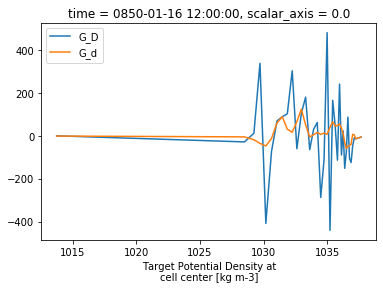

In [8]:
G_D.plot(label='G_D')
G_d.plot(label='G_d')
plt.legend()

### Layer-wise budgets for oxygen
From Groeskamp et al. (2019), the change of globally integrated tracer content ($[C]$) between two $\lambda$ contours is given by:
$$ \frac{d[C]}{dt}= \Delta_{\lambda} E_C(\rho_l) + [F^{mass}_C] + \Delta_{\lambda}[M^{dia}_C(\rho2_l)] + [F^{tracer}_C] + [B_C] $$  
where
$$ E_C = \frac{\partial}{\partial \lambda}\iiint \rho c \dot{\lambda} dV $$  
is the flux of tracer due to water mass transformation, where $c$ is the local tracer concentration. $F$'s represent the flux of tracer at the surface due to mass fluxes and direct tracer fluxes (e.g. air-sea gas exchange), $M^{dia}_C$ represents diffusive tracer fluxes across the bounding contours, $B_C$ respresents sources or sinks due to biogeochemical processes. $\Delta_\lambda$'s denote the difference in that flux between the two bounding contours, square brackets denote the integral of that flux between the bounding contours.

In [30]:
# Take the cell-integrated rhodrho term, multiply it by the local oxygen concentration, and integrate globally
crhodrho_int = (ds.o2*rhodrho_cell).sum(dim=['xh','yh']).squeeze()
crhoDrho_int = (ds.o2*rhoDrho_cell).sum(dim=['xh','yh']).squeeze()
# Divide by the density difference
E_d = crhodrho_int/dr
E_D = crhoDrho_int/dr

In [31]:
# Interpolate E onto layer interfaces, and take the difference
E_d = E_d.interp(rho2_l=ds.rho2_i,method='cubic').diff('rho2_i').assign_coords(rho2_i = ds.rho2_l.values).drop('rho2_l').rename({'rho2_i':'rho2_l'})
E_D = E_D.interp(rho2_l=ds.rho2_i,method='cubic').diff('rho2_i').assign_coords(rho2_i = ds.rho2_l.values).drop('rho2_l').rename({'rho2_i':'rho2_l'})

In [11]:
# Integrate up all of the other terms
# o2_vdiffuse_impl includes both diffusion across layer interfaces and the air-sea gas exchange and the bottom boundary layer input
MF = (ds.o2_vdiffuse_impl*area3d).sum(dim=['xh','yh'])
# jo2_plus_btm includes all of the biogeochemistry sources and sinks. Unfortunately it will double-count the bottom boundary exchange.
B = (ds.jo2_plus_btm*area3d).sum(dim=['xh','yh'])
# Also sum up the o2h_tendency
C = (ds.o2h_tendency*area3d).sum(dim=['xh','yh'])

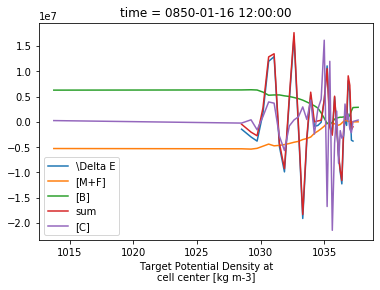

In [12]:
E_d.plot(label = '\Delta E')
MF.plot(label = '[M+F]')
B.plot(label = '[B]')
(E_d+MF+B).plot(label='sum')
C.plot(label = '[C]')
plt.legend()

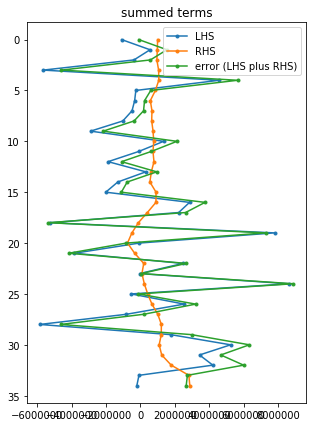

In [14]:
# Just sum up the tendencies in each layer directly
termsLHS = ['o2h_tendency','o2_advection_xy','o2h_tendency_vert_remap']
termsRHS = ['o2_dfxy_cont_tendency','o2_vdiffuse_impl','jo2_plus_btm']
area3d = ds_native.areacello*xr.ones_like(ds.o2)
ds_int = xr.ones_like(ds_native.areacello)
for var in termsLHS:
    term_int = (ds[var]*area3d).sum(['xh','yh'])
    term_int.name = var
    ds_int = xr.merge([ds_int,term_int])
for var in termsRHS:
    term_int = (ds[var]*area3d).sum(['xh','yh'])
    term_int.name = var
    ds_int = xr.merge([ds_int,term_int])
signsLHS = [-1,1,1]
signsRHS = [1,1,1]
Do2, do2, errors = bc.calc_materialderivative(ds_int.squeeze(),termsLHS,signsLHS,termsRHS,signsRHS,vertc='rho2_l',plot=True)

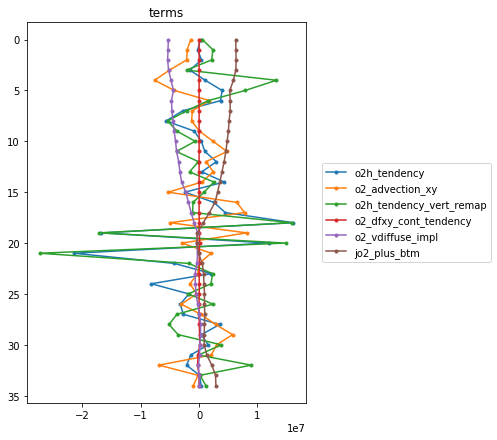

In [23]:
bc.plot_budgetterms(ds_int.squeeze(),termsLHS+termsRHS,vertc='rho2_l')

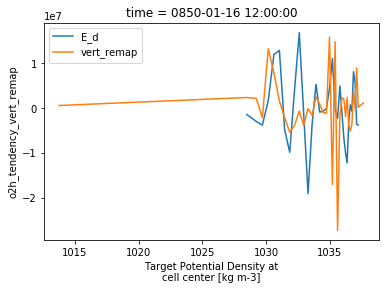

In [33]:
E_d.plot(label='E_d')
ds_int.o2h_tendency_vert_remap.plot(label='vert_remap');
plt.legend()